In [1]:
%autosave 0
import numpy as np
import pandas as pd

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

from datetime import date, timedelta
from joblib import dump

import warnings
warnings.filterwarnings("ignore") 

Autosave disabled


Start Day : 28/03

Trying to predict number of new cases & deaths one day before

Working with data update everyday here : https://ourworldindata.org/coronavirus-source-data
I take the full dataset linked

In [2]:
## Today Data scrap on nb 00 
df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")

In [3]:
df.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,ABW,North America,Aruba,2020-03-13,2.0,2.0,NaN,0.0,0.0,NaN,...,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29
1,ABW,North America,Aruba,2020-03-19,NaN,NaN,0.286,NaN,NaN,0.0,...,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29
2,ABW,North America,Aruba,2020-03-20,4.0,2.0,0.286,0.0,0.0,0.0,...,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29


In [4]:
df.tail(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
38046,NaN,NaN,International,2020-03-08,NaN,NaN,0.000,NaN,NaN,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38047,NaN,NaN,International,2020-03-09,NaN,NaN,0.000,NaN,NaN,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38048,NaN,NaN,International,2020-03-10,696.0,-9.0,-1.286,7.0,1.0,0.143,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df['location'].unique()

array(['Aruba', 'Afghanistan', 'Angola', 'Anguilla', 'Albania', 'Andorra',
       'United Arab Emirates', 'Argentina', 'Armenia',
       'Antigua and Barbuda', 'Australia', 'Austria', 'Azerbaijan',
       'Burundi', 'Belgium', 'Benin', 'Bonaire Sint Eustatius and Saba',
       'Burkina Faso', 'Bangladesh', 'Bulgaria', 'Bahrain', 'Bahamas',
       'Bosnia and Herzegovina', 'Belarus', 'Belize', 'Bermuda',
       'Bolivia', 'Brazil', 'Barbados', 'Brunei', 'Bhutan', 'Botswana',
       'Central African Republic', 'Canada', 'Switzerland', 'Chile',
       'China', "Cote d'Ivoire", 'Cameroon',
       'Democratic Republic of Congo', 'Congo', 'Colombia', 'Comoros',
       'Cape Verde', 'Costa Rica', 'Cuba', 'Curacao', 'Cayman Islands',
       'Cyprus', 'Czech Republic', 'Germany', 'Djibouti', 'Dominica',
       'Denmark', 'Dominican Republic', 'Algeria', 'Ecuador', 'Egypt',
       'Eritrea', 'Western Sahara', 'Spain', 'Estonia', 'Ethiopia',
       'Finland', 'Fiji', 'Falkland Islands', 'France',

# Data Exploration

In [6]:
def massBalance(subject,df,country):
    """ Plot evolution of data by columns
    params :
        subject = name of cols concerned by the plot
        df = The Dataframe
        country = Name of location isolated for the plot
    """
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.line(x=df["date"], y=df[f"{subject}"])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [7]:
## Plotly graph will be not display on Git ##
# massBalance("total_deaths",df,"World")
# massBalance("total_deaths",df,"France")
# massBalance("total_deaths",df,"China")
# massBalance("total_deaths",df,"Italy")
# massBalance("total_deaths",df,"Spain")
# massBalance("total_deaths",df,"United States")
# massBalance("total_deaths",df,"Germany")
# massBalance("total_deaths",df,"Iran")
# massBalance("total_deaths",df,"Turkey")
# massBalance("total_deaths",df,"Brazil")

In [8]:
## Plotly graph will be not display on Git ##
# massBalance("total_cases",df,"World")
# massBalance("total_cases",df,"France")
# massBalance("total_cases",df,"China")
# massBalance("total_cases",df,"Italy")
# massBalance("total_cases",df,"Spain")
# massBalance("total_cases",df,"United States")
# massBalance("total_cases",df,"United Kingdom")
# massBalance("total_cases",df,"Germany")
# massBalance("total_cases",df,"Iran")
# massBalance("total_cases",df,"Turkey")
# massBalance("total_cases",df,"Brazil")

In [9]:
def newOverTime(subject,df,country):
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.bar(df, x=df["date"], y=df[f'{subject}'])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [10]:
## Plotly graph will be not display on Git ##
# newOverTime("new_cases",df,"World")
# newOverTime("new_cases",df,"France")
# newOverTime("new_cases",df,"China")
# newOverTime("new_cases",df,"Italy")
# newOverTime("new_cases",df,"Spain")
# newOverTime("new_cases",df,"United States")
# newOverTime("new_cases",df,"United Kingdom")
# newOverTime("new_cases",df,"Germany")
# newOverTime("new_cases",df,"Iran")
# newOverTime("new_cases",df,"Turkey")
# newOverTime("new_cases",df,"Brazil")

In [11]:
## Plotly graph will be not display on Git ##
# newOverTime("new_deaths",df,"World")
# newOverTime("new_deaths",df,"France")
# newOverTime("new_deaths",df,"China")
# newOverTime("new_deaths",df,"Italy")
# newOverTime("new_deaths",df,"Spain")
# newOverTime("new_deaths",df,"United States")
# newOverTime("new_deaths",df,"United Kingdom")
# newOverTime("new_deaths",df,"Germany")
# newOverTime("new_deaths",df,"Iran")
# newOverTime("new_deaths",df,"Turkey")
# newOverTime("new_deaths",df,"Brazil")

In [12]:
def worldrep(subject,graph_long=5,val_larg=1000000,df=df):
    fidf_mod = df.sort_values(subject, axis=0, ascending =False).head(500)
    f, ax = plt.subplots(figsize=(15, graph_long))

    ax.set(xlim=(0, val_larg), 
           ylabel= "Pays",
           xlabel= subject,
           Title= (f"{subject} by country")
          )
    ax.legend()
    sns.despine(top=True)
    ax = sns.barplot(x=fidf_mod[subject], y=fidf_mod["location"])


No handles with labels found to put in legend.


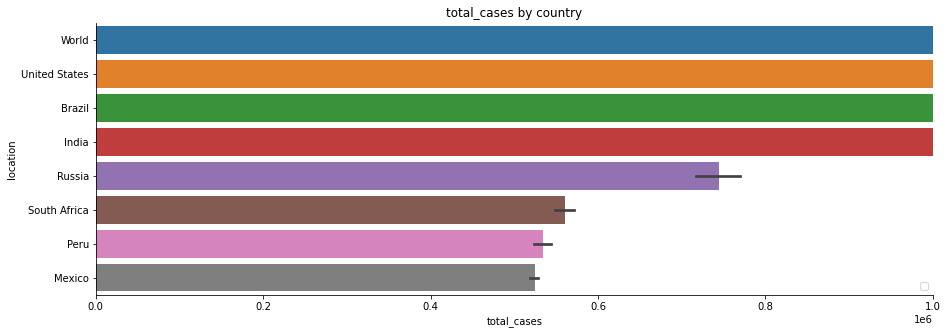

In [13]:
worldrep("total_cases")

No handles with labels found to put in legend.


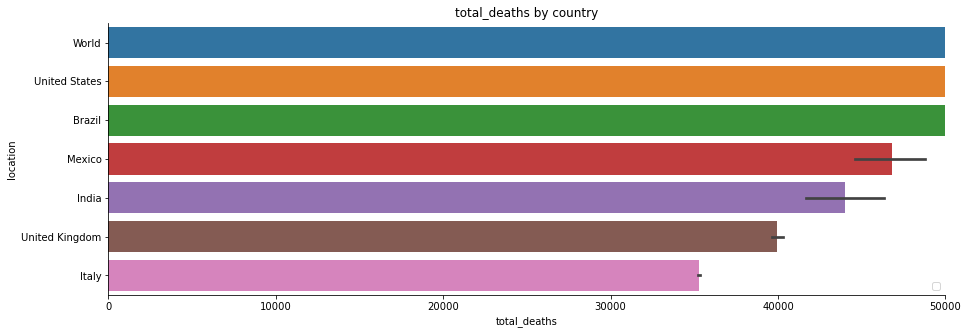

In [14]:
worldrep("total_deaths",val_larg=50000)

In [15]:
dds = df[df["date"].isin([f'{date.today()}'])]

No handles with labels found to put in legend.


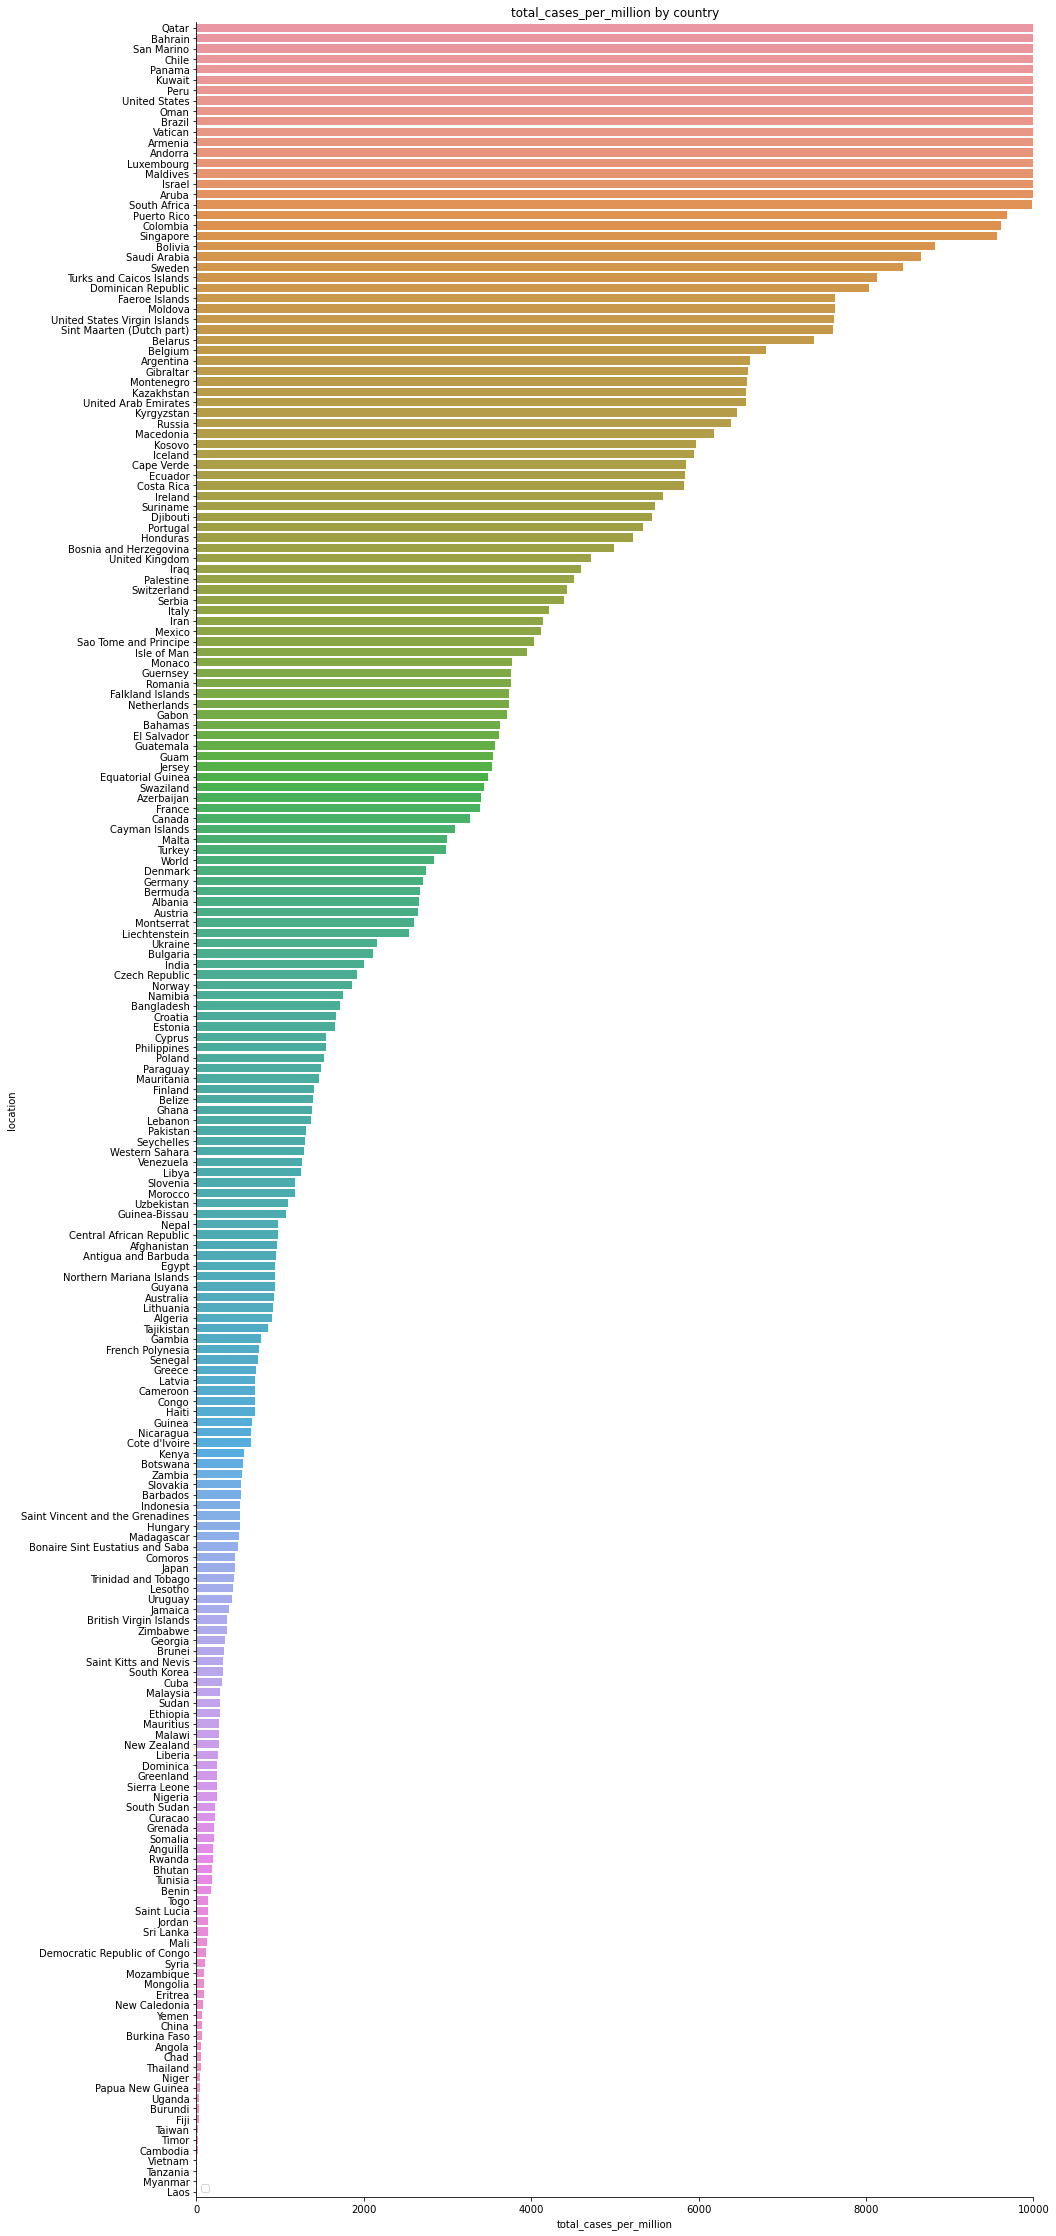

In [16]:
try:
    worldrep("total_cases_per_million",graph_long=40,val_larg=10000,df=dds)
except:
    print("Not today")

No handles with labels found to put in legend.


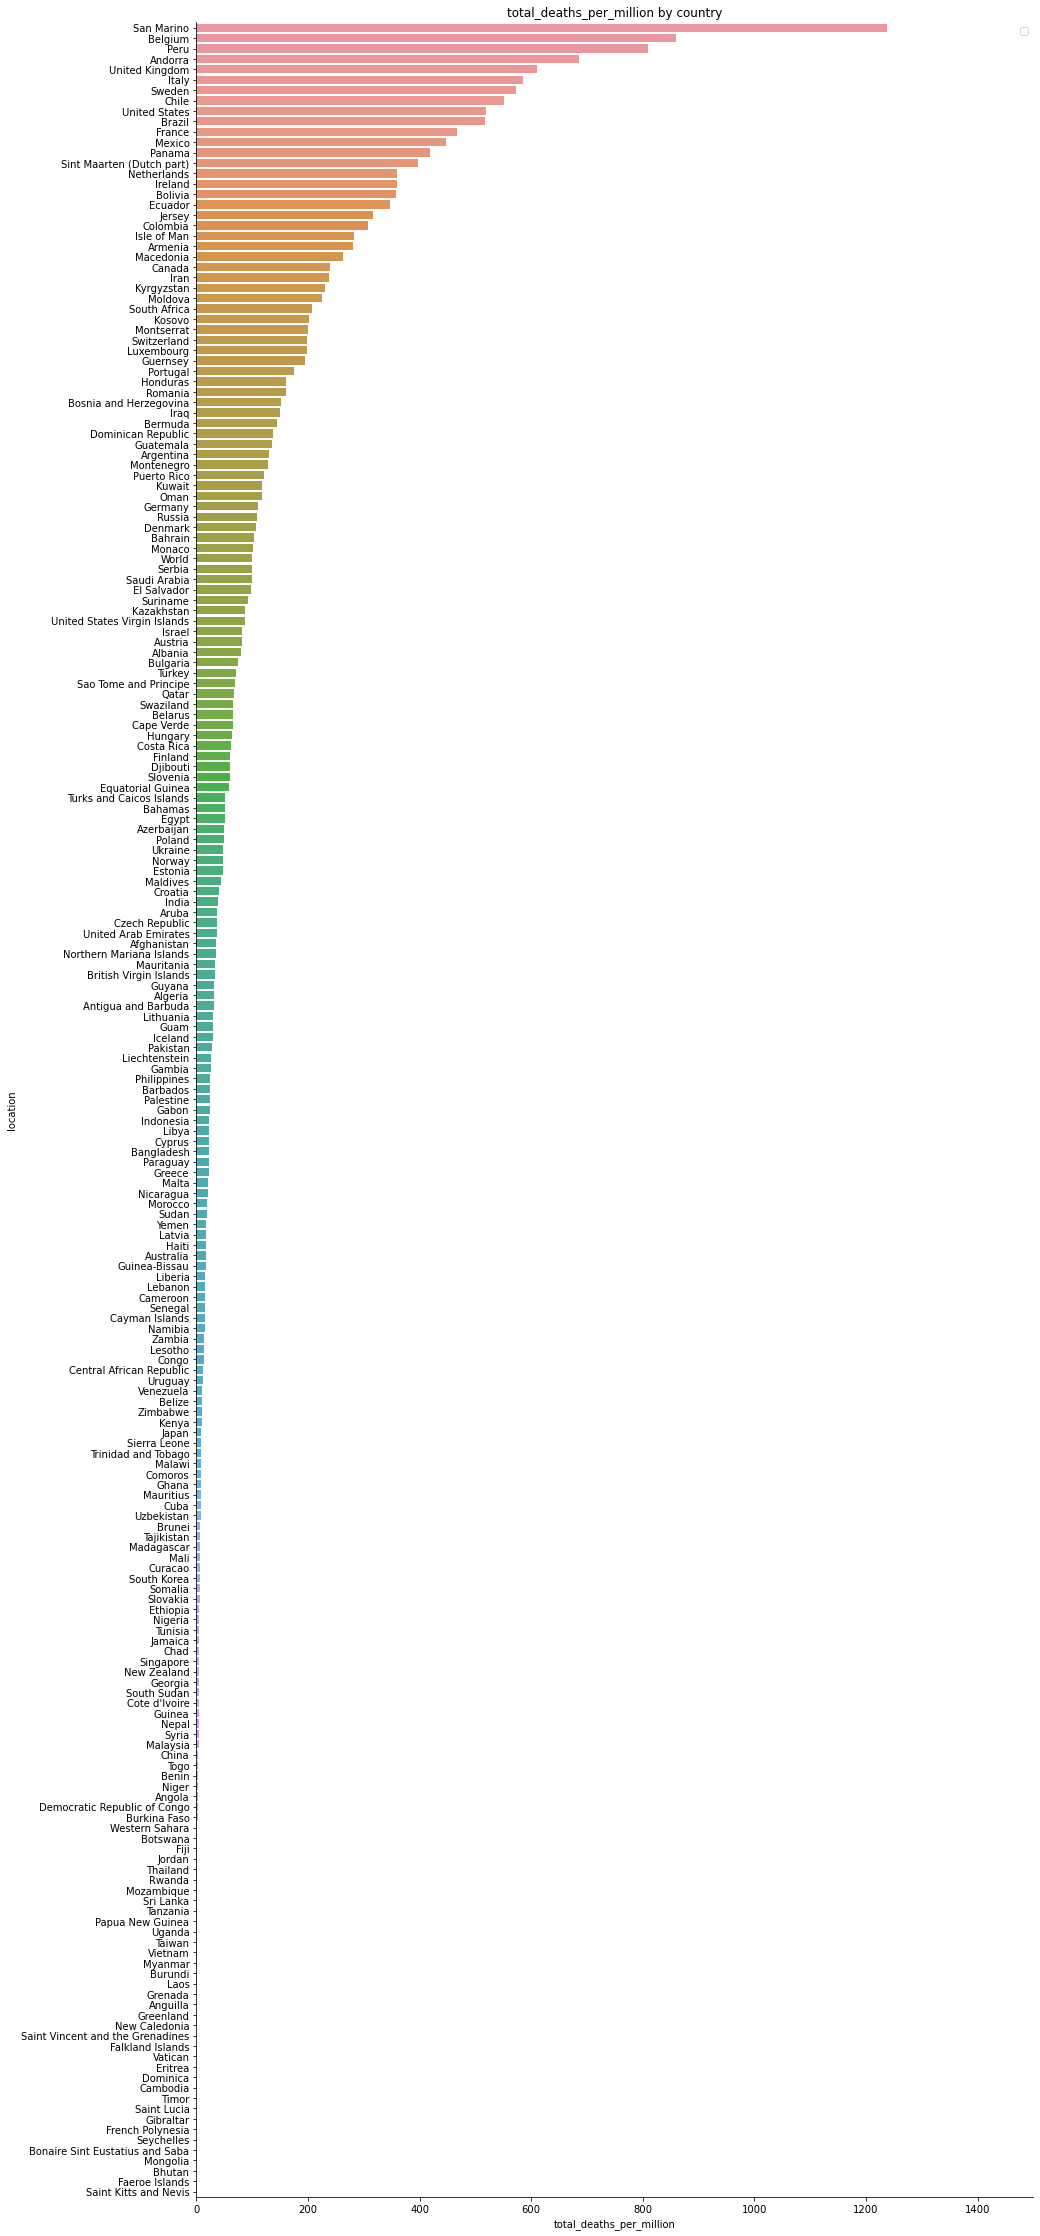

In [17]:
try :
    worldrep("total_deaths_per_million",graph_long=40,val_larg=1500,df=dds)
    is_full_data = True
except:
    is_full_data = False
    print("not today")

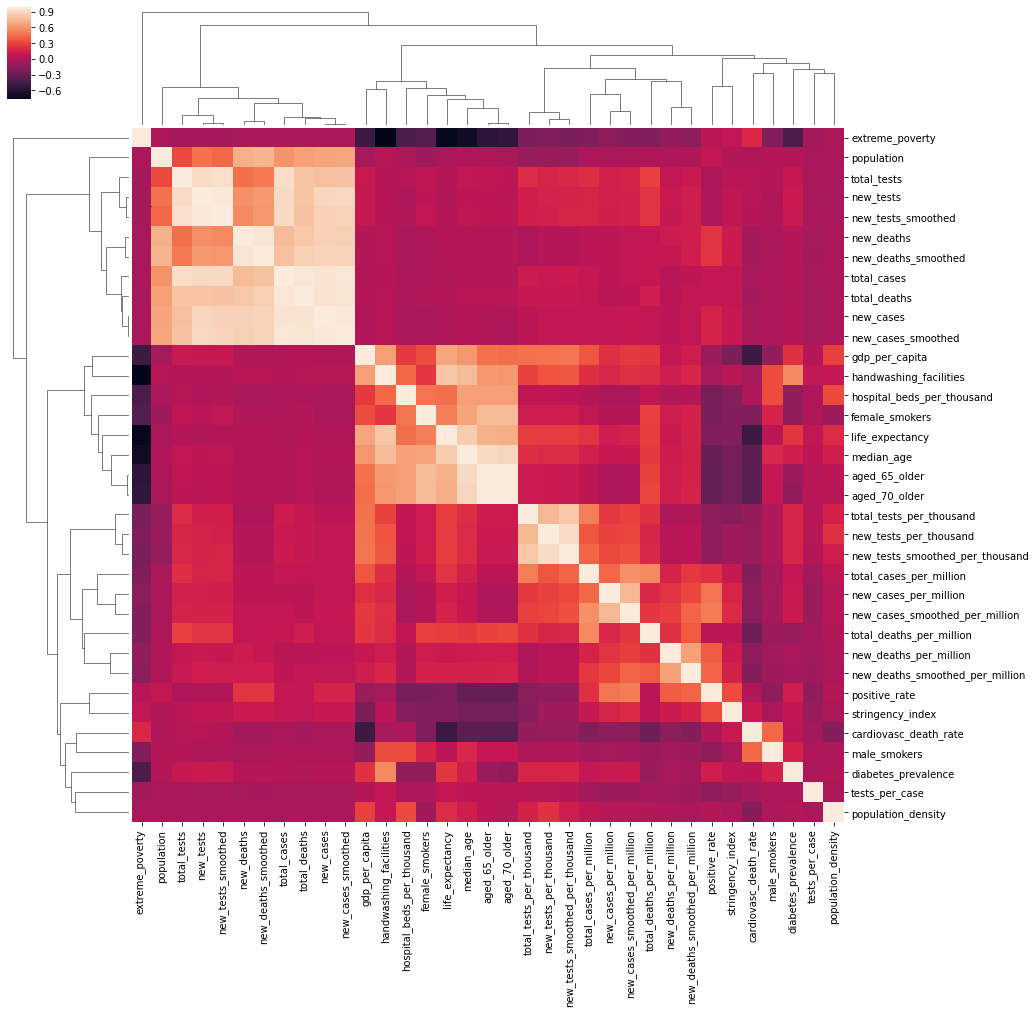

In [18]:
if is_full_data:
    corr = df.corr()
    sns.clustermap(corr,figsize=(15, 15))
else :
    print("not today")

# Modeling routines

In [19]:
def createModel(subject,periode,country,n_splits=3,max_iter=5000):
    
    df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")
    df = df[df['location'].isin([f"{country}"])] 
    vals = df[[f"{subject}"]].values
    
    imp = SimpleImputer(missing_values=np.nan, strategy='constant')
    vals = imp.fit_transform(vals)
    
    hisShape = vals.shape[0]
    x_train = []
    y_train = []

    for i in range(periode,hisShape):
        x_train.append(vals[(i-periode):i,0]) 
        y_train.append(vals[i,0])

    x_train = np.array(x_train) 
    y_train = np.array(y_train)
    
    ###############################################################
    model = ElasticNet(random_state=0,max_iter=max_iter) 
    # tol=0.01 by reducing this hp warning disapear, pred will be highter 
    ###############################################################
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = cross_val_score(model, x_train, y_train, cv=tscv)
    print(f"R^2: {scores.mean()} (+/- {scores.std()})")
    
    model.fit(x_train,y_train)
    print("Coef : ",model.coef_)
    
    return vals, x_train,y_train, model

In [20]:
def predicTomorow(vals,model,periode):
    tmw = vals[-periode:]
    lili = []
    for i in tmw:
        lili.append(int(i))
    lili = np.array(lili).reshape(1, -1) 
    res = int(model.predict(lili))
    last_day = lili[0][periode-1]
    diff_betw = res-last_day
    print(f"{periode} Last_days : ",lili)
    print("Today : ",last_day)
    print("Prediction + : ",diff_betw)
    print("Tomorow : ",res)
    return last_day, res

In [21]:
def conbine(subject,periode,country):
    vals, x_train, y_train, model = createModel(subject,periode,country)
    last_day, ress = predicTomorow(vals,model,periode)
    return last_day, ress

In [22]:
def fullRoutines(df,periode,country):
    print(f"********* For {country} **************")
    print("                                     ")
    print("--------- Total Cases -----------------")
    print("                                     ")
    last_day_cases, res1 = conbine("total_cases",periode,f"{country}")
    print("                                     ")
    print("--------- Total Death -----------------")
    print("                                     ")
    last_day_death, res2 = conbine("total_deaths",periode,f"{country}")
    print("                                     ")
    return last_day_cases, last_day_death, res1, res2

# Prediction Tomorow

In [23]:
periode = 3

In [24]:
last_day_cases, last_day_death, res1ww, res2ww = fullRoutines(df,periode,"World")
world_data = last_day_cases, last_day_death, res1ww, res2ww

********* For World **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9995720315817018 (+/- 0.00018987929002010283)
Coef :  [1.04188264e+00 8.43890590e-05 9.34875749e-05]
3 Last_days :  [[21706551 21901632 22151281]]
Today :  22151281
Prediction + :  537088
Tomorow :  22688369
                                     
--------- Total Death -----------------
                                     
R^2: 0.9994724957837363 (+/- 0.0002173807152846456)
Coef :  [-0.07580676  0.52331636  0.56234281]
3 Last_days :  [[770313 774574 781123]]
Today :  781123
Prediction + :  7250
Tomorow :  788373
                                     


In [25]:
last_day_casesfr, last_day_deathfr, res1fr, res2fr = fullRoutines(df,periode,"France")
french_data = last_day_casesfr, last_day_deathfr, res1fr, res2fr

********* For France **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9720552739715497 (+/- 0.03111608961202155)
Coef :  [-0.66852425  0.73597295  0.9332522 ]
3 Last_days :  [[218536 219029 221267]]
Today :  221267
Prediction + :  659
Tomorow :  221926
                                     
--------- Total Death -----------------
                                     
R^2: 0.4008046626515218 (+/- 0.8353815440605439)
Coef :  [-0.7551006   0.78841468  0.96580562]
3 Last_days :  [[30410 30429 30451]]
Today :  30451
Prediction + :  37
Tomorow :  30488
                                     


In [26]:
last_day_casesch, last_day_deathch, res1ch, res2ch = fullRoutines(df,periode,"China")
china_data = last_day_casesch, last_day_deathch, res1ch, res2ch

********* For China **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.8209766508915467 (+/- 0.1263043514227333)
Coef :  [-0.32186645 -0.02484023  1.34097952]
3 Last_days :  [[89375 89441 89494]]
Today :  89494
Prediction + :  55
Tomorow :  89549
                                     
--------- Total Death -----------------
                                     
R^2: -1304.4747018489784 (+/- 1845.9588029854158)
Coef :  [-0.07662525  0.01240996  1.05625006]
3 Last_days :  [[4703 4703 4705]]
Today :  4705
Prediction + :  7
Tomorow :  4712
                                     


In [27]:
last_day_casesit, last_day_deathit, res1it, res2it = fullRoutines(df,periode,"Italy")
italy_data = last_day_casesit, last_day_deathit, res1it, res2it

********* For Italy **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.7637217551981901 (+/- 0.33268279503153686)
Coef :  [-0.83666584  0.90446194  0.93139174]
3 Last_days :  [[253915 254235 254636]]
Today :  254636
Prediction + :  405
Tomorow :  255041
                                     
--------- Total Death -----------------
                                     
R^2: 0.9015556555922455 (+/- 0.10901245779179441)
Coef :  [-0.83468912  0.90255827  0.93132773]
3 Last_days :  [[35396 35400 35405]]
Today :  35405
Prediction + :  26
Tomorow :  35431
                                     


In [28]:
try:
    last_day_casessp, last_day_deathsp, res1sp, res2sp = fullRoutines(df,periode,"Spain")
    spain_data = last_day_casessp, last_day_deathsp, res1sp, res2sp
except:
    print("No spain update")

********* For Spain **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.7422493220169145 (+/- 0.3527658839900139)
Coef :  [-0.7250117   0.59948229  1.12625299]
3 Last_days :  [[342813 359082 364196]]
Today :  364196
Prediction + :  12900
Tomorow :  377096
                                     
--------- Total Death -----------------
                                     
R^2: 0.2523043074674145 (+/- 0.8926039824934355)
Coef :  [-0.71804705  0.60982001  1.10723497]
3 Last_days :  [[28617 28646 28670]]
Today :  28670
Prediction + :  32
Tomorow :  28702
                                     


In [29]:
last_day_casesus, last_day_deathus, res1us, res2us = fullRoutines(df,periode,"United States")
usa_data = last_day_casesus, last_day_deathus, res1us, res2us

********* For United States **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9974400782743219 (+/- 0.0031965293812752874)
Coef :  [0.08506945 0.45836655 0.47593894]
3 Last_days :  [[5403269 5438325 5482416]]
Today :  5482416
Prediction + :  90362
Tomorow :  5572778
                                     
--------- Total Death -----------------
                                     
R^2: 0.4785385471533141 (+/- 0.7357801898106286)
Coef :  [-0.62499132  0.76644939  0.86072795]
3 Last_days :  [[170052 170497 171821]]
Today :  171821
Prediction + :  720
Tomorow :  172541
                                     


In [30]:
last_day_casesuk, last_day_deathuk, res1uk, res2uk = fullRoutines(df,periode,"United Kingdom")
uk_data = last_day_casesuk, last_day_deathuk, res1uk, res2uk

********* For United Kingdom **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9837084011947651 (+/- 0.02198515444438839)
Coef :  [-0.78005895  0.87609582  0.90404122]
3 Last_days :  [[318484 319197 320286]]
Today :  320286
Prediction + :  911
Tomorow :  321197
                                     
--------- Total Death -----------------
                                     
R^2: 0.43814756850097897 (+/- 0.7734693814784946)
Coef :  [-0.77706776  0.8328082   0.94377584]
3 Last_days :  [[41366 41369 41381]]
Today :  41381
Prediction + :  41
Tomorow :  41422
                                     


In [31]:
last_day_casesger, last_day_deathger, res1ger, res2ger = fullRoutines(df,periode,"Germany")
ger_data = last_day_casesger, last_day_deathger, res1ger, res2ger

********* For Germany **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9804460028109446 (+/- 0.024265426153589825)
Coef :  [-0.8116576   0.86661783  0.94463544]
3 Last_days :  [[224014 224014 226914]]
Today :  226914
Prediction + :  42
Tomorow :  226956
                                     
--------- Total Death -----------------
                                     
R^2: 0.4369010616285913 (+/- 0.7846443077570406)
Coef :  [-0.79674259  0.8424497   0.95369859]
3 Last_days :  [[9232 9232 9243]]
Today :  9243
Prediction + :  6
Tomorow :  9249
                                     


In [32]:
last_day_casesIran, last_day_deathIran, res1Iran, res2Iran = fullRoutines(df,periode,"Iran")
Iran_data = last_day_casesIran, last_day_deathIran, res1Iran, res2Iran

********* For Iran **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.060599952894911824 (+/- 1.3279397257921535)
Coef :  [0.17382035 0.42006863 0.41901862]
3 Last_days :  [[343203 345450 347835]]
Today :  347835
Prediction + :  3882
Tomorow :  351717
                                     
--------- Total Death -----------------
                                     
R^2: 0.8867204849480587 (+/- 0.15986349766546862)
Coef :  [-0.03065589  0.52617853  0.51857338]
3 Last_days :  [[19639 19804 19972]]
Today :  19972
Prediction + :  244
Tomorow :  20216
                                     


In [33]:
last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk = fullRoutines(df,periode,"Turkey")
Turk_data = last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk

********* For Turkey **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9975040281799205 (+/- 0.003274029830120624)
Coef :  [-0.75838345  0.85797557  0.89759703]
3 Last_days :  [[249309 250542 251805]]
Today :  251805
Prediction + :  1076
Tomorow :  252881
                                     
--------- Total Death -----------------
                                     
R^2: 0.9995082194100542 (+/- 0.000374039777000071)
Coef :  [-0.82243863  0.90026095  0.91918727]
3 Last_days :  [[5974 5996 6016]]
Today :  6016
Prediction + :  19
Tomorow :  6035
                                     


In [34]:
last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz = fullRoutines(df,periode,"Brazil")
Braz_data = last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz

********* For Brazil **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.46291092120094496 (+/- 0.7567906526150234)
Coef :  [-0.19692905  0.48952539  0.72482233]
3 Last_days :  [[3340197 3359570 3407354]]
Today :  3407354
Prediction + :  53945
Tomorow :  3461299
                                     
--------- Total Death -----------------
                                     
R^2: 0.5049455154319079 (+/- 0.6962808342959123)
Coef :  [-0.20758651  0.5543693   0.66608252]
3 Last_days :  [[107852 108536 109888]]
Today :  109888
Prediction + :  1294
Tomorow :  111182
                                     


In [35]:
model_data = [world_data, french_data, italy_data, spain_data, usa_data,
              china_data, uk_data, ger_data, Iran_data, Turk_data, Braz_data]

In [36]:
model_data

[(22151281, 781123, 22688369, 788373),
 (221267, 30451, 221926, 30488),
 (254636, 35405, 255041, 35431),
 (364196, 28670, 377096, 28702),
 (5482416, 171821, 5572778, 172541),
 (89494, 4705, 89549, 4712),
 (320286, 41381, 321197, 41422),
 (226914, 9243, 226956, 9249),
 (347835, 19972, 351717, 20216),
 (251805, 6016, 252881, 6035),
 (3407354, 109888, 3461299, 111182)]

In [37]:
# dump(model_data, "endPoint/CovidDataPred.joblib")

In [38]:
def popPred(country,rez1,rez2):
    pop_pred = pd.DataFrame()

    pop_pred.loc[0,"date"] = date.today()
    pop_pred.loc[0,"country"] = country
    pop_pred.loc[0,"total_cases_predict"] = rez1
    pop_pred.loc[0,"total_cases_real"] = 0
    pop_pred.loc[0,"total_deaths_predict"] = rez2
    pop_pred.loc[0,"total_deaths_real"] = 0
    pop_pred.loc[0,"error_abs_cases"] = 0
    pop_pred.loc[0,"error_abs_deaths"] = 0
    
    return pop_pred

In [39]:
df_pop_pred1 = popPred("France",res1fr, res2fr)
df_pop_pred2 = popPred("China",res1ch, res2ch)
df_pop_pred3 = popPred("Italy",res1it, res2it)
df_pop_pred4 = popPred("Spain",res1sp, res2sp)
df_pop_pred5 = popPred("United States",res1us, res2us)
df_pop_pred6 = popPred("World",res1ww, res2ww)
df_pop_pred7 = popPred("United Kingdom",res1uk, res2uk)
df_pop_pred8 = popPred("Germany",res1ger, res2ger)
df_pop_pred9 = popPred("Iran",res1Iran, res2Iran)
df_pop_pred10 = popPred("Turkey",res1Turk, res2Turk)
df_pop_pred11 = popPred("Brazil",res1Braz, res2Braz)

frames = [df_pop_pred1, df_pop_pred2, df_pop_pred3, df_pop_pred4,
          df_pop_pred5, df_pop_pred6, df_pop_pred7, df_pop_pred8,
          df_pop_pred9, df_pop_pred10, df_pop_pred11]

predpred = pd.concat(frames)
predpred

,date,country,total_cases_predict,total_cases_real,total_deaths_predict,total_deaths_real,error_abs_cases,error_abs_deaths
0,2020-08-19,France,221926.0,0.0,30488.0,0.0,0.0,0.0
0,2020-08-19,China,89549.0,0.0,4712.0,0.0,0.0,0.0
0,2020-08-19,Italy,255041.0,0.0,35431.0,0.0,0.0,0.0
0,2020-08-19,Spain,377096.0,0.0,28702.0,0.0,0.0,0.0
0,2020-08-19,United States,5572778.0,0.0,172541.0,0.0,0.0,0.0
0,2020-08-19,World,22688369.0,0.0,788373.0,0.0,0.0,0.0
0,2020-08-19,United Kingdom,321197.0,0.0,41422.0,0.0,0.0,0.0
0,2020-08-19,Germany,226956.0,0.0,9249.0,0.0,0.0,0.0
0,2020-08-19,Iran,351717.0,0.0,20216.0,0.0,0.0,0.0
0,2020-08-19,Turkey,252881.0,0.0,6035.0,0.0,0.0,0.0


In [40]:
predpred.to_csv(f"AzureSC\\Pred\\predDf{date.today()}.csv")